# Homework 3: VQ-VAE and WGAN

```
your solution
```

In [ ]:
COMMIT_HASH = "79dfd7865ba692235f0a4d5aed20ee2820a19007"
!if [ -d dgm_utils ]; then rm -Rf dgm_utils; fi
!git clone https://github.com/r-isachenko/dgm_utils.git
%cd dgm_utils
!git checkout {COMMIT_HASH}
!pip install ./
%cd ./..
!rm -Rf dgm_utils

In [1]:
from dgm_utils import train_model, train_adversarial
from dgm_utils import show_samples, visualize_images, load_dataset
from dgm_utils import BaseModel

In [2]:
import os
import numpy as np

from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

if torch.cuda.is_available():
    DEVICE = "cuda"
    print('GPU found :)')
else:
    DEVICE = "cpu"
    print('GPU not found :(')

GPU found :)


## Task 2: VQ-VAE on MNIST (5 pt)

### Training of VQ-VAE model

In this part you will train [VQ-VAE](https://arxiv.org/abs/1711.00937) model that we have discussed at the lecture (see also [VQ-VAE-2](https://arxiv.org/abs/1906.00446) paper).

We will you MNIST dataset in this task.

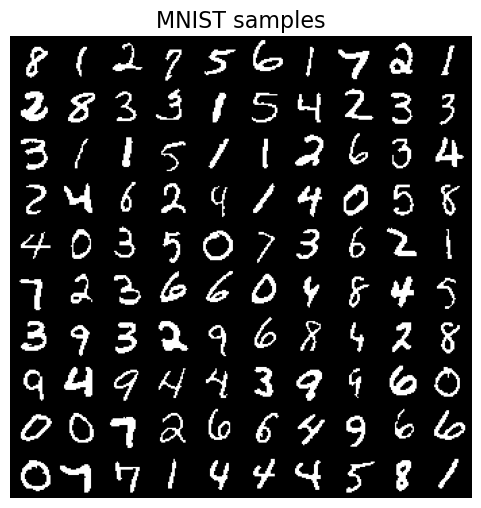

In [3]:
train_data, test_data = load_dataset("mnist", flatten=False, binarize=True)
train_data, test_data = train_data.astype("float32"), test_data.astype("float32")
visualize_images(train_data, "MNIST samples")

VQ-VAE model is a VAE model with discrete latent variable.  

**Reminder:**
* We define  dictionary (word book) space $\{\mathbf{e}_k\}_{k=1}^K$, where $\mathbf{e}_k \in \mathbb{R}^C$, $K$ is the size of the dictionary.
* $\mathbf{z}_e = \text{NN}_e(\mathbf{x}, \boldsymbol{\phi})$ - continuous output of encoder network.
* $\mathbf{z}_q = \mathbf{e}_{k^*}$ is a quantized representation, where $k^* = \text{argmin}_k \| \mathbf{z} - \mathbf{e}_k \|$. It is simple nearest neighbor look up.
* Out deterministic variational posterior:
$$
  q(c = k^* | \mathbf{x}, \boldsymbol{\phi}) = \begin{cases}
  1 , \quad \text{for } k^* = \text{argmin}_k \| \mathbf{z}_e - \mathbf{e}_k \|; \\
  0, \quad \text{otherwise}.
\end{cases}
$$
* Prior distribution is uniform: $p(c) = \text{Uniform}\{1, \dots, K\}$.
* KL divergence between posterior and prior:
$$
  KL(q(c = k^* | \mathbf{x}, \boldsymbol{\phi}), p(c)) = \log K.
$$
* ELBO:
$$
		\mathcal{L} (\boldsymbol{\phi}, \boldsymbol{\theta})  = \mathbb{E}_{q(c | \mathbf{x}, \boldsymbol{\phi})} \log p(\mathbf{x} | \mathbf{e}_{c} , \boldsymbol{\theta}) - \log K =  \log p(\mathbf{x} | \mathbf{z}_q, \boldsymbol{\theta}) - \log K.
$$
* Vector quantization is non-differentiable operation. We will use **straight-through** gradient estimator (we will copy gradients from decoder input $\mathbf{z}_q$ to encoder output $\mathbf{z}_e$.

**Important modifications:**
Due to the straight-through gradient estimation of mapping from $\mathbf{z}_e$ to $\mathbf{z}_q$, the embeddings $\mathbf{e}$ receive no gradients from the ELBO.

Therefore, in order to learn the embedding space we add l2 loss (**codebook loss**) to move the embedding vectors $\mathbf{e}$ towards the encoder outputs $\mathbf{z}_e$.

Finally, since the volume of the embedding space is dimensionless, it can grow arbitrarily if the embeddings $\mathbf{e}$ do not train as fast as the encoder parameters. To make sure the encoder commits to an embedding and its output does not grow, we add a **commitment loss**.

Thus, the total training objective becomes:
$$
  \log p(\mathbf{x}| \mathbf{z}_q, \boldsymbol{\theta}) + \| \text{stop\_gradient}(\mathbf{z}_e) - \mathbf{e}\|_2^2 + \| \mathbf{z}_e - \text{stop\_gradient}(\mathbf{e})\|_2^2.
$$

Pay attention to the $\text{stop\_gradient}(*)$ operator.


Our first step is implement vector quantization procedure. It will also calculate two consistency losses.

In [4]:
class VectorQuantizer(nn.Module):
    def __init__(
        self, num_embeddings: int = 128, embedding_dim: int = 16, beta: float = 0.25
    ) -> None:
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        self.beta = beta

        # Initialize the embeddings which we will quantize.
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)

    def get_code_indices(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(0, 2, 3, 1).contiguous()
        input_shape = x.shape[:-1]
        flattened = x.view(-1, self.embedding_dim)
        # ====
        # your code
        # 1) calculate distances from flatten inputs to embeddings
        # 2) find nearest embeddings to each input (use argmin op)
        distances = torch.cdist(flattened, self.embedding.weight)
        encoding_indices = torch.argmin(distances, dim=1)
        # ====
        encoding_indices = encoding_indices.view(input_shape)
        return encoding_indices

    def get_quantized(self, encoding_indices: torch.Tensor) -> torch.Tensor:
        # ====
        # your code
        # 1) get embeddgins with appropriate indices
        # 2) transform tensor from BHWC to BCHW format
        quantized = self.embedding(encoding_indices)
        quantized = quantized.permute(0, 3, 1, 2).contiguous()
        # ====
        return quantized

    def forward(self, x: torch.Tensor) -> tuple:
        # ====
        # your code
        # 1) get indices
        # 2) get quantized latents
        # 3) calculate codebook and commitment loss
        #    do not afraid about stop_gradient op
        #    (use .detach() method for quantized latents and x)
        # 4) final loss is codebook_loss + beta * commitment_loss
        encoding_indices = self.get_code_indices(x)
        quantized = self.get_quantized(encoding_indices)
        
        # Codebook loss: move embeddings towards encoder outputs
        codebook_loss = F.mse_loss(quantized.detach(), x)
        # Commitment loss: make encoder commit to embeddings
        commitment_loss = F.mse_loss(x, quantized.detach())
        loss = codebook_loss + self.beta * commitment_loss
        # ====

        # Straight-through estimator (think about it!).
        quantized = x + (quantized - x).detach()

        return quantized, loss


def test_vector_quantizer():
    x = torch.zeros((1, 16, 7, 7))
    layer = VectorQuantizer()
    indices = layer.get_code_indices(x)
    assert indices.shape == (1, 7, 7)
    quantized = layer.get_quantized(indices)
    assert quantized.shape == (1, 16, 7, 7)
    quantized, loss = layer(x)
    assert quantized.shape == (1, 16, 7, 7)
    assert loss.shape == ()


test_vector_quantizer()

We will use simple encoder/decoder with several strided convolutions.

In [5]:
class ConvEncoder(nn.Module):
    def __init__(self, latent_dim: int) -> None:
        super().__init__()
        # ====
        # your code
        # define Sequential model with Conv2d and ReLU activation
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 14x14 -> 7x7
            nn.ReLU(),
            nn.Conv2d(64, latent_dim, kernel_size=3, stride=1, padding=1),  # 7x7 -> 7x7
        )
        # ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class ConvDecoder(nn.Module):
    def __init__(self, latent_dim: int) -> None:
        super().__init__()
        # ====
        # your code
        # define Sequential model with ConvTransposed2d and ReLU activation
        self.net = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 64, kernel_size=3, stride=1, padding=1),  # 7x7 -> 7x7
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 2, kernel_size=4, stride=2, padding=1),  # 14x14 -> 28x28
        )
        # ====

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        return self.net(z)

Now we are ready to define our model. It consists of encoder, decoder and vector quantizer.

In [6]:
class VQVAEModel(BaseModel):
    def __init__(
        self,
        ce_loss_scale: float = 1.0,
        latent_dim: int = 16,
        num_embeddings: int = 64,
        latent_size: tuple = (7, 7),
    ) -> None:
        super().__init__()
        self.encoder = ConvEncoder(latent_dim)
        self.decoder = ConvDecoder(latent_dim)
        self.vq_layer = VectorQuantizer(num_embeddings, latent_dim)
        self.ce_loss_scale = ce_loss_scale
        self.latent_size = latent_size

    def forward(self, x: torch.Tensor) -> tuple:
        # ====
        # your code
        # 1) apply encoder
        # 2) apply vector quantizer (it returns quantized representation + vq_loss)
        # 3) apply decoder (it returns decoded samples)
        encoded = self.encoder(x)
        quantized, vq_loss = self.vq_layer(encoded)
        decoded = self.decoder(quantized)
        # ====
        return decoded, vq_loss

    def loss(self, x: torch.Tensor) -> dict:
        # ====
        # your code
        # 1) apply model
        # 2) get cross entropy loss
        decoded, vq_loss = self.forward(x)
        # For binary MNIST, we use BCE with logits
        # decoded shape: (B, 2, H, W) - logits for binary classification
        # x shape: (B, 1, H, W) - binary values
        ce_loss = F.binary_cross_entropy_with_logits(
            decoded[:, 0:1, :, :], x, reduction='mean'
        )
        # ====
        return {
            "total_loss": self.ce_loss_scale * ce_loss + vq_loss,
            "ce_loss": self.ce_loss_scale * ce_loss,
            "vq_loss": vq_loss,
        }

    def get_indices(self, x: torch.Tensor) -> torch.Tensor:
        # ====
        # your code
        # 1) apply encoder
        # 2) get indices of codes using vector quantizer
        encoded = self.encoder(x)
        codebook_indices = self.vq_layer.get_code_indices(encoded)
        # ====
        return codebook_indices

    def prior(self, n: int) -> torch.Tensor:
        # ====
        # your code
        # prior distribution is uniform
        # 1) get samples from categorical distribution
        # 2) get quantized representations using vector quantizer
        # Uniform prior: sample indices uniformly from [0, num_embeddings)
        indices = torch.randint(
            0, self.vq_layer.num_embeddings, 
            size=(n, *self.latent_size)
        ).to(next(self.parameters()).device)
        quantized = self.vq_layer.get_quantized(indices)
        # ====
        return quantized

    def sample_from_logits(self, logits: torch.Tensor) -> np.ndarray:
        # ====
        # your code
        # our model will return logits, this method applies softmax and samples from the distribution
        # 1) apply softmax to the logits
        # 2) sample from the distribution (e.x. you could use torch.multinomial)
        # be careful with the sizes of the tensors (may be you need to permute/reshape dimensios)
        # logits shape: (B, 2, H, W) - logits for binary classification
        # For binary MNIST, we sample from Bernoulli distribution
        probs = torch.sigmoid(logits[:, 0:1, :, :])
        samples = torch.bernoulli(probs)
        # ====
        return samples.cpu().detach().numpy()

    def sample(self, n: int) -> np.ndarray:
        with torch.no_grad():
            # ====
            # your code
            # 1) sample from prior distribution
            # 2) apply decoder
            # 3) sample from logits
            quantized = self.prior(n)
            logits = self.decoder(quantized)
            samples = self.sample_from_logits(logits)
            # ====
            return samples.astype(float)


def test_vqvae_model():
    model = VQVAEModel().cuda()
    x = torch.zeros((2, 1, 28, 28)).cuda()

    encoded = model.encoder(x)
    size = encoded.shape[2:]
    assert size == model.latent_size

    indices = model.get_indices(x)
    assert indices.shape == (2, 7, 7)

    losses = model.loss(x)
    assert isinstance(losses, dict)
    assert "total_loss" in losses

    quantized = model.prior(10)
    assert quantized.shape == (10, 16, *model.latent_size)

    decoded = model.decoder(quantized)
    assert decoded.shape == (10, 2, 28, 28)

    sampled = model.sample(10)
    assert sampled.shape == (10, 1, 28, 28)


test_vqvae_model()

Let's train our model!

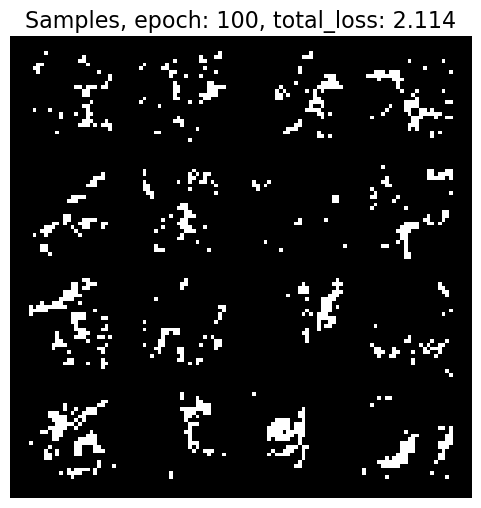

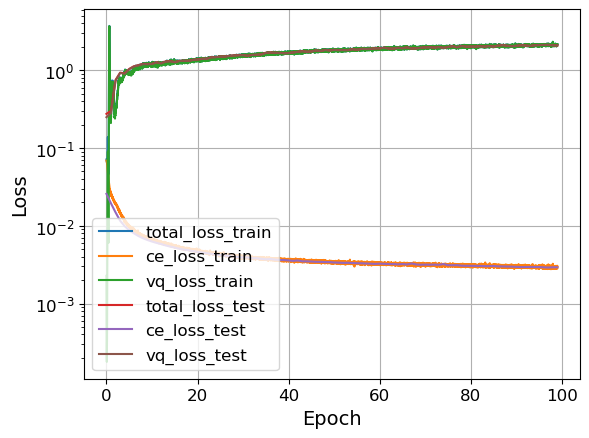

End of the training


In [7]:
# ====
# your code
# choose these parameters
BATCH_SIZE = 512
EPOCHS = 100
LR = 1e-3
CE_SCALE = 1e-1
# ====

model = VQVAEModel(ce_loss_scale=CE_SCALE, latent_dim=32, num_embeddings=128)

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

# ====
# your code
# choose any optimizer/scheduler as you want
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# ====

train_model(
    model,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    optimizer=optimizer,
    device=DEVICE,
    n_samples=16,
    visualize_samples=True,
    logscale_y=True,
)

Now we is able to sample from the trained model.

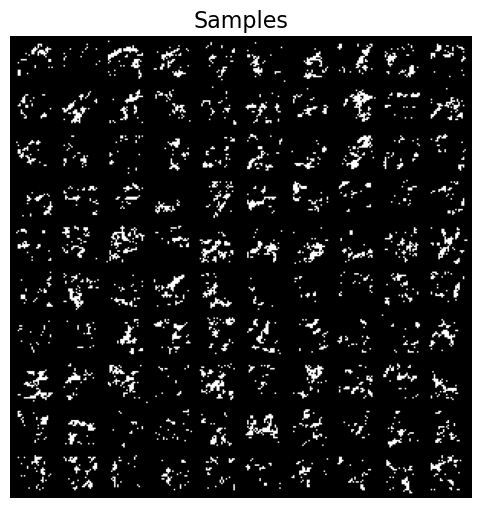

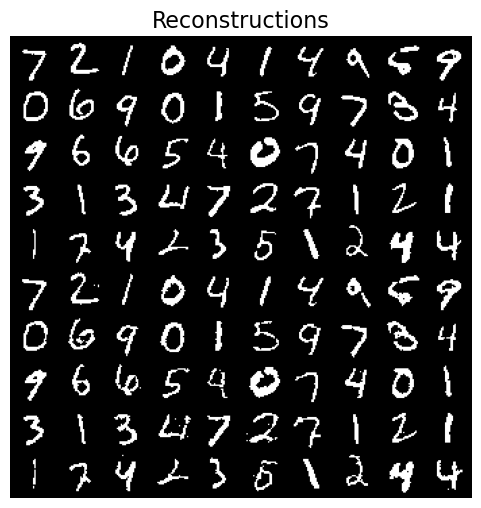

In [8]:
# Samples
samples = model.sample(100)
show_samples(samples, title="Samples")

# Reconstructions
output = next(iter(test_loader))[:50].cuda()
with torch.no_grad():
    decoded, _ = model(output)
    x_recon = model.sample_from_logits(decoded)
output = output.cpu().numpy()
reconstructions = np.concatenate((output, x_recon), axis=0)
reconstructions = reconstructions.astype("float32")
show_samples(reconstructions, title="Reconstructions")

Probably you will get bad samples :(

Do not worry, may be it is ok, we will try to fix your samples! Make sure that reconstructions are almost perfect.

Here, we will visualize latent code indices for test images.

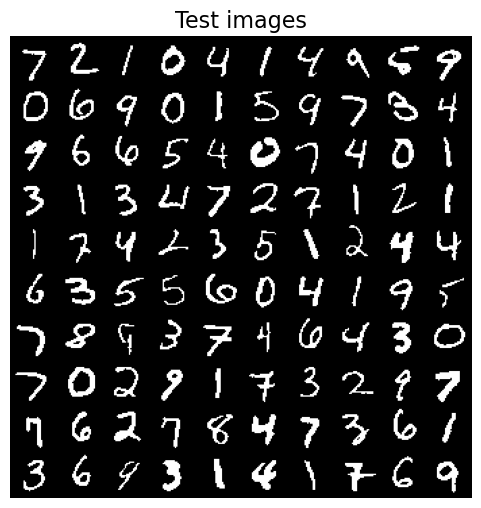

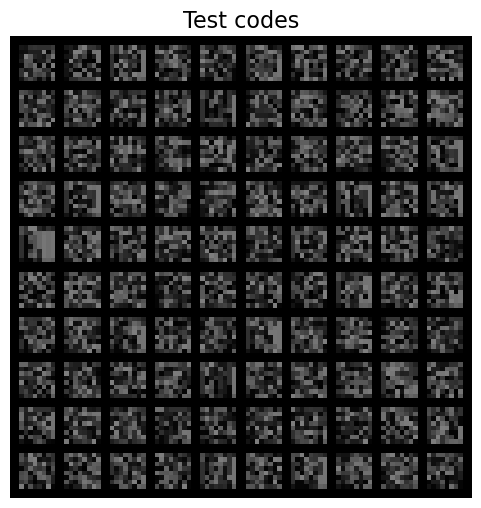

In [9]:
test_images = next(iter(test_loader))[:100]
output = test_images.cuda()
codebook_indices = model.get_indices(output).cpu().unsqueeze(1)

show_samples(test_images, "Test images")
show_samples(codebook_indices, "Test codes")

### Training of prior autoregressive model

The samples from our VQ-VAE model is not good enough. The authors of the original VQ-VAE paper proposed to train autoregressive model in the latent space after we trained VQ-VAE model.

Remember we have discussed **ELBO surgery** and **aggregrated posterior**. Let recall what do we have in VAE:
* **Training:** we get latent variables $\mathbf{z}$ from variational posterior $q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi})$ for every object $\mathbf{x}$ and then applies decoder ($p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta})$). It means that in average decoder is applied to the latent variables from aggregated posterior $q_{\text{agg}}(\mathbf{z} | \boldsymbol{\phi})$.
* **Inference:** We apply decoder to the latent variables from prior distribution $p(\mathbf{z})$.

It means that if our aggregated posterior $q_{\text{agg}}(\mathbf{z} | \boldsymbol{\phi})$ and prior $p(\mathbf{z})$ is too far from each other, then we get inconsistency.

So let train to remove this inconsistency. To be concrete, let train (autoregressive) model in the latent space that will try to predict samples from the aggregated posterior $q_{\text{agg}}(\mathbf{z} | \boldsymbol{\phi})$.

We will use our good friend: PixelCNN model.

In [10]:
class MaskedConv2d(nn.Conv2d):
    def __init__(
        self, mask_type: str, in_channels: int, out_channels: int, kernel_size: int = 5
    ) -> None:
        assert mask_type in ["A", "B"]
        super().__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
        )
        self.register_buffer("mask", torch.zeros_like(self.weight))
        self.create_mask(mask_type)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ====
        # your code

        # Apply mask to weights before convolution
        self.weight.data *= self.mask
        return super().forward(x)

    def create_mask(self, mask_type: str) -> None:
        # ====
        # your code
        # do not forget about mask_type

        # For causal convolution, we mask future pixels
        # Center of kernel is at (kernel_size // 2, kernel_size // 2)
        center = self.kernel_size[0] // 2
        for i in range(self.kernel_size[0]):
            for j in range(self.kernel_size[0]):
                # Mask pixels to the right and below the center
                if i > center or (i == center and j > center):
                    self.mask[:, :, i, j] = 0
                elif i == center and j == center:
                    # Type A: mask center, Type B: allow center
                    self.mask[:, :, i, j] = 1 if mask_type == "B" else 0
                else:
                    self.mask[:, :, i, j] = 1


def test_masked_conv2d():
    layer = MaskedConv2d("A", 2, 2)
    assert np.allclose(layer.mask[:, :, 2, 2].numpy(), np.zeros((2, 2)))

    layer = MaskedConv2d("B", 2, 2)
    assert np.allclose(layer.mask[:, :, 2, 2].numpy(), np.ones((2, 2)))


test_masked_conv2d()

In [11]:
class PixelCNN(BaseModel):
    def __init__(
        self,
        num_embeddings: int = 128,
        input_shape: tuple = (8, 8),
        n_filters: int = 32,
        kernel_size: int = 5,
        n_layers: int = 5,
    ) -> None:

        super().__init__()
        self.input_shape = input_shape
        self.num_embeddings = num_embeddings

        # ====
        # your code
        # apply the sequence of MaskedConv2d -> ReLU
        # the last layer should be MaskedConv2d (not ReLU)
        # Note 1: the first conv layer should be of type 'A'
        # Note 2: final output_dim in MaskedConv2d must be 2
        layers = []
        # First layer: type 'A', input is num_embeddings (one-hot), output is n_filters
        layers.append(MaskedConv2d("A", num_embeddings, n_filters, kernel_size))
        layers.append(nn.ReLU())
        
        # Middle layers: type 'B', n_filters -> n_filters
        for _ in range(n_layers - 2):
            layers.append(MaskedConv2d("B", n_filters, n_filters, kernel_size))
            layers.append(nn.ReLU())
        
        # Last layer: type 'B', n_filters -> num_embeddings
        # Note: The forward method reshapes to (B, num_embeddings, 1, H, W), so output must be num_embeddings channels
        layers.append(MaskedConv2d("B", n_filters, num_embeddings, kernel_size))
        
        self.net = nn.Sequential(*layers)
        # ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # read the forward method carefully
        flattened = x.view((-1, 1))
        encodings = torch.zeros(flattened.shape[0], self.num_embeddings).cuda()
        encodings.scatter_(1, flattened, 1)
        encodings = encodings.view((-1, *self.input_shape, self.num_embeddings))
        encodings = encodings.permute((0, 3, 1, 2))
        out = self.net(encodings)
        out = out.view(-1, self.num_embeddings, 1, *self.input_shape)
        return out

    def loss(self, x: torch.Tensor) -> dict:
        # ====
        # your code
        # x shape: (B, 1, H, W) - indices
        # Forward pass gives logits: (B, num_embeddings, 1, H, W)
        logits = self.forward(x)  # (B, num_embeddings, 1, H, W)
        # Reshape for cross entropy: (B*H*W, num_embeddings)
        logits = logits.squeeze(2).permute(0, 2, 3, 1).contiguous()
        logits = logits.view(-1, self.num_embeddings)
        # Targets: (B, 1, H, W) -> (B*H*W,)
        targets = x.view(-1).long()
        # Cross entropy loss
        total_loss = F.cross_entropy(logits, targets)        
        # ====
        return {"total_loss": total_loss}

    def sample(self, n: int) -> np.ndarray:
        # read carefully the sampling process
        samples = torch.zeros(n, 1, *self.input_shape, dtype=torch.int64).cuda()
        with torch.no_grad():
            for r in range(self.input_shape[0]):
                for c in range(self.input_shape[1]):
                    logits = self(samples)[:, :, :, r, c]
                    probs = F.softmax(logits, dim=1).squeeze(-1)
                    samples[:, 0, r, c] = torch.multinomial(
                        probs, num_samples=1
                    ).squeeze(-1)
        return samples.cpu().numpy()


def test_pixelcnn():
    model = PixelCNN().cuda()
    x = torch.zeros((1, 1, 8, 8), dtype=torch.int64).cuda()
    output = model(x)
    assert output.shape == (1, 128, 1, 8, 8)
    losses = model.loss(x)
    assert isinstance(losses, dict)
    assert "total_loss" in losses
    samples = model.sample(10)
    assert samples.shape == (10, 1, 8, 8)


test_pixelcnn()

Now we need to get our train and test samples. Our model will predict indices of the embeddings.

In [12]:
# ====
# your code
# you have to get indices of the emdeddings from the VQ-VAE model for train and test data
INPUT_SHAPE = [8, 8] 
model.eval()
train_indices = []
test_indices = []

with torch.no_grad():
    # Get indices for train data
    train_loader_indices = data.DataLoader(train_data, batch_size=512, shuffle=False)
    for batch in train_loader_indices:
        batch = torch.Tensor(batch).to(DEVICE)
        indices = model.get_indices(batch).cpu().numpy()
        train_indices.append(indices)
    train_indices = np.concatenate(train_indices, axis=0)
    train_indices = train_indices[:, np.newaxis, :, :]  # Add channel dimension
    
    # Get indices for test data
    test_loader_indices = data.DataLoader(test_data, batch_size=512, shuffle=False)
    for batch in test_loader_indices:
        batch = torch.Tensor(batch).to(DEVICE)
        indices = model.get_indices(batch).cpu().numpy()
        test_indices.append(indices)
    test_indices = np.concatenate(test_indices, axis=0)
    test_indices = test_indices[:, np.newaxis, :, :]  # Add channel dimension
# ====
assert isinstance(train_indices, np.ndarray)
assert isinstance(test_indices, np.ndarray)
assert train_indices.shape == (60000, 1, *INPUT_SHAPE)
assert test_indices.shape == (10000, 1, *INPUT_SHAPE)

Epoch: 50, loss: 1.838152164843545


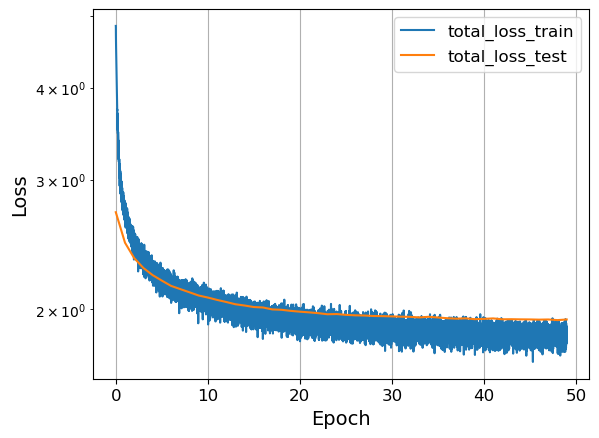

End of the training


In [14]:
# ====
# your code
# choose these parameters by your own
EPOCHS = 50
BATCH_SIZE = 128
LR = 1e-3
N_LAYERS = 5
N_FILTERS = 64
# ====

prior_model = PixelCNN(
    input_shape=INPUT_SHAPE, n_filters=N_FILTERS, kernel_size=5, n_layers=N_LAYERS
)

train_loader = data.DataLoader(train_indices, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_indices, batch_size=BATCH_SIZE)

# ====
# your code
# choose any optimizer/scheduler as you want
optimizer = torch.optim.Adam(prior_model.parameters(), lr=LR)
# ====

train_model(
    prior_model,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    optimizer=optimizer,
    device=DEVICE,
    visualize_samples=False,
    logscale_y=True,
)

Now we are ready to sample from our VQ-VAE model. The difference here that we will sample our embedding indices from the PixelCNN prior model instead of the Uniform prior distribution.

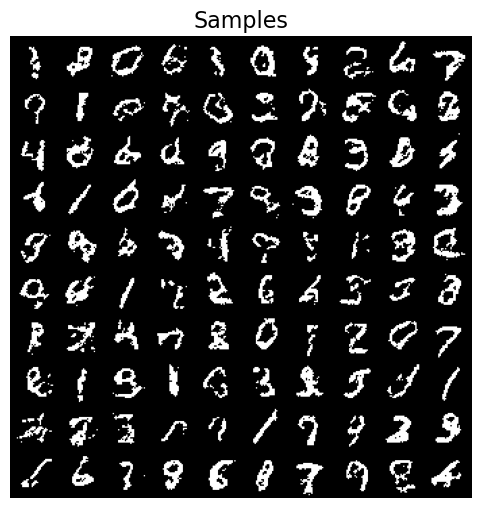

In [15]:
N_SAMPLES = 100
indices = prior_model.sample(N_SAMPLES).squeeze(1)
quantized = model.vq_layer.get_quantized(torch.Tensor(indices).int().cuda())
logits = model.decoder(quantized)
samples = model.sample_from_logits(logits)

samples = samples.astype("float32")
show_samples(samples, title="Samples")